In [10]:
# Aminov Rezo
import numpy as np
import wave
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import random

import struct

from keras.models import *
from keras.layers import *
from keras.callbacks import *

import librosa
import soundfile as sf

In [3]:
DATA_DIR = 'data_v_7_stc'

1 2 16000 70080
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0]


/home/aminov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


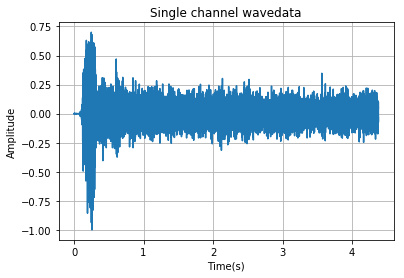

In [4]:
test_file = "{}/audio/background_0007.wav".format(DATA_DIR)

with wave.open(test_file, 'rb') as f:
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    print(nchannels, sampwidth, framerate, nframes) 
    strData = f.readframes(nframes)

waveData = np.fromstring(strData, dtype=np.int16)

print(waveData[:20])

waveData_norm = waveData * 1.0 / (max(abs(waveData)))

time = np.arange(0, nframes)*(1.0 / framerate)
plt.plot(time, waveData_norm)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Single channel wavedata")
plt.grid('on')
plt.show()

## Load DF

In [5]:
meta_file = "{}/meta/meta.txt".format(DATA_DIR)

In [6]:
df = pd.read_csv(meta_file, sep='\t',header=None)

In [7]:
df.head()

,0,1,2,3,4
0,background_0001.wav,office,0,9.458500,background
1,background_0001_time_stretch_0.wav,office,0,9.989070,background
2,background_0001_time_stretch_1.wav,office,0,9.879410,background
3,background_0001_time_stretch_10.wav,office,0,11.156553,background
4,background_0001_time_stretch_11.wav,office,0,13.261587,background


In [9]:
# mean time
df[3].mean()

5.351487826656803

In [8]:
# все уникальные лейблы
labels_name = df[4].unique()

In [10]:
# кодирование лейблов
onehot_dict = {}
for ii, lab in enumerate(labels_name):
    y_ = np.zeros(len(labels_name))
    y_[ii] = 1
    onehot_dict.update({lab:ii})

In [15]:
# экстрактор фич: Мел-кепстральные коэффициенты (MFCC). https://habr.com/post/140828/
def extract_feature(file_name):
    X, sample_rate = sf.read(file_name, dtype='float32')
    if X.ndim > 1:
        X = X[:,0]
    X = X.T
    # преобразование Фурье
    stft = np.abs(librosa.stft(X))
    # MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    # chroma
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    # мэл спектр
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    # спектр-ный контраст
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

In [11]:
features, labels = np.empty((0,193)), np.empty(0)
for file, label in zip(df[0],df[4]):    
    try:
        mfccs, chroma, mel, contrast,tonnetz = extract_feature(DATA_DIR+'/audio/'+file)
    except Exception as e:
        print("[Error] extract feature error. %s" % (e))
        continue
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    labels = np.append(labels, onehot_dict[label])
    print("extract %s features done" % (file))


extract background_0001.wav features done
extract background_0001_time_stretch_0.wav features done
extract background_0001_time_stretch_1.wav features done
extract background_0001_time_stretch_10.wav features done
extract background_0001_time_stretch_11.wav features done
extract background_0001_time_stretch_12.wav features done
extract background_0001_time_stretch_13.wav features done
extract background_0001_time_stretch_2.wav features done
extract background_0001_time_stretch_3.wav features done
extract background_0001_time_stretch_4.wav features done
extract background_0001_time_stretch_5.wav features done
extract background_0001_time_stretch_6.wav features done
extract background_0001_time_stretch_7.wav features done
extract background_0001_time_stretch_8.wav features done
extract background_0001_time_stretch_9.wav features done
extract background_0002.wav features done
extract background_0002_time_stretch_0.wav features done
extract background_0002_time_stretch_1.wav features done


extract background_0010_time_stretch_6.wav features done
extract background_0010_time_stretch_7.wav features done
extract background_0010_time_stretch_8.wav features done
extract background_0010_time_stretch_9.wav features done
extract background_0011.wav features done
extract background_0011_time_stretch_0.wav features done
extract background_0011_time_stretch_1.wav features done
extract background_0011_time_stretch_10.wav features done
extract background_0011_time_stretch_11.wav features done
extract background_0011_time_stretch_12.wav features done
extract background_0011_time_stretch_13.wav features done
extract background_0011_time_stretch_2.wav features done
extract background_0011_time_stretch_3.wav features done
extract background_0011_time_stretch_4.wav features done
extract background_0011_time_stretch_5.wav features done
extract background_0011_time_stretch_6.wav features done
extract background_0011_time_stretch_7.wav features done
extract background_0011_time_stretch_8.wav

extract background_0020_time_stretch_2.wav features done
extract background_0020_time_stretch_3.wav features done
extract background_0020_time_stretch_4.wav features done
extract background_0020_time_stretch_5.wav features done
extract background_0020_time_stretch_6.wav features done
extract background_0020_time_stretch_7.wav features done
extract background_0020_time_stretch_8.wav features done
extract background_0020_time_stretch_9.wav features done
extract background_0021.wav features done
extract background_0021_time_stretch_0.wav features done
extract background_0021_time_stretch_1.wav features done
extract background_0021_time_stretch_10.wav features done
extract background_0021_time_stretch_11.wav features done
extract background_0021_time_stretch_12.wav features done
extract background_0021_time_stretch_13.wav features done
extract background_0021_time_stretch_2.wav features done
extract background_0021_time_stretch_3.wav features done
extract background_0021_time_stretch_4.wav

extract background_0030_time_stretch_10.wav features done
extract background_0030_time_stretch_11.wav features done
extract background_0030_time_stretch_12.wav features done
extract background_0030_time_stretch_13.wav features done
extract background_0030_time_stretch_2.wav features done
extract background_0030_time_stretch_3.wav features done
extract background_0030_time_stretch_4.wav features done
extract background_0030_time_stretch_5.wav features done
extract background_0030_time_stretch_6.wav features done
extract background_0030_time_stretch_7.wav features done
extract background_0030_time_stretch_8.wav features done
extract background_0030_time_stretch_9.wav features done
extract background_0031.wav features done
extract background_0031_time_stretch_0.wav features done
extract background_0031_time_stretch_1.wav features done
extract background_0031_time_stretch_10.wav features done
extract background_0031_time_stretch_11.wav features done
extract background_0031_time_stretch_12.

extract background_0039_time_stretch_9.wav features done
extract background_0040.wav features done
extract background_0040_time_stretch_0.wav features done
extract background_0040_time_stretch_1.wav features done
extract background_0040_time_stretch_10.wav features done
extract background_0040_time_stretch_11.wav features done
extract background_0040_time_stretch_12.wav features done
extract background_0040_time_stretch_13.wav features done
extract background_0040_time_stretch_2.wav features done
extract background_0040_time_stretch_3.wav features done
extract background_0040_time_stretch_4.wav features done
extract background_0040_time_stretch_5.wav features done
extract background_0040_time_stretch_6.wav features done
extract background_0040_time_stretch_7.wav features done
extract background_0040_time_stretch_8.wav features done
extract background_0040_time_stretch_9.wav features done
extract background_0041.wav features done
extract background_0041_time_stretch_0.wav features done


extract background_0049_time_stretch_5.wav features done
extract background_0049_time_stretch_6.wav features done
extract background_0049_time_stretch_7.wav features done
extract background_0049_time_stretch_8.wav features done
extract background_0049_time_stretch_9.wav features done
extract background_0050.wav features done
extract background_0050_time_stretch_0.wav features done
extract background_0050_time_stretch_1.wav features done
extract background_0050_time_stretch_10.wav features done
extract background_0050_time_stretch_11.wav features done
extract background_0050_time_stretch_12.wav features done
extract background_0050_time_stretch_13.wav features done
extract background_0050_time_stretch_2.wav features done
extract background_0050_time_stretch_3.wav features done
extract background_0050_time_stretch_4.wav features done
extract background_0050_time_stretch_5.wav features done
extract background_0050_time_stretch_6.wav features done
extract background_0050_time_stretch_7.wav

extract background_0059_time_stretch_13.wav features done
extract background_0059_time_stretch_2.wav features done
extract background_0059_time_stretch_3.wav features done
extract background_0059_time_stretch_4.wav features done
extract background_0059_time_stretch_5.wav features done
extract background_0059_time_stretch_6.wav features done
extract background_0059_time_stretch_7.wav features done
extract background_0059_time_stretch_8.wav features done
extract background_0059_time_stretch_9.wav features done
extract background_0060.wav features done
extract background_0060_time_stretch_0.wav features done
extract background_0060_time_stretch_1.wav features done
extract background_0060_time_stretch_10.wav features done
extract background_0060_time_stretch_11.wav features done
extract background_0060_time_stretch_12.wav features done
extract background_0060_time_stretch_13.wav features done
extract background_0060_time_stretch_2.wav features done
extract background_0060_time_stretch_3.wa

extract background_0069_time_stretch_1.wav features done
extract background_0069_time_stretch_10.wav features done
extract background_0069_time_stretch_11.wav features done
extract background_0069_time_stretch_12.wav features done
extract background_0069_time_stretch_13.wav features done
extract background_0069_time_stretch_2.wav features done
extract background_0069_time_stretch_3.wav features done
extract background_0069_time_stretch_4.wav features done
extract background_0069_time_stretch_5.wav features done
extract background_0069_time_stretch_6.wav features done
extract background_0069_time_stretch_7.wav features done
extract background_0069_time_stretch_8.wav features done
extract background_0069_time_stretch_9.wav features done
extract background_0070.wav features done
extract background_0070_time_stretch_0.wav features done
extract background_0070_time_stretch_1.wav features done
extract background_0070_time_stretch_10.wav features done
extract background_0070_time_stretch_11.w

extract bags_0013_time_stretch_1.wav features done
extract bags_0013_time_stretch_3.wav features done
extract bags_0014.wav features done
extract bags_0014_time_stretch_0.wav features done
extract bags_0014_time_stretch_1.wav features done
extract bags_0014_time_stretch_3.wav features done
extract bags_0015.wav features done
extract bags_0015_time_stretch_0.wav features done
extract bags_0015_time_stretch_1.wav features done
extract bags_0015_time_stretch_3.wav features done
extract bags_0016.wav features done
extract bags_0016_time_stretch_0.wav features done
extract bags_0016_time_stretch_1.wav features done
extract bags_0016_time_stretch_3.wav features done
extract bags_0017.wav features done
extract bags_0017_time_stretch_0.wav features done
extract bags_0017_time_stretch_1.wav features done
extract bags_0017_time_stretch_3.wav features done
extract bags_0018.wav features done
extract bags_0018_time_stretch_0.wav features done
extract bags_0018_time_stretch_1.wav features done
extr

extract bg_0014_time_stretch_1.wav features done
extract bg_0014_time_stretch_3.wav features done
extract bg_0015.wav features done
extract bg_0015_time_stretch_0.wav features done
extract bg_0015_time_stretch_1.wav features done
extract bg_0015_time_stretch_3.wav features done
extract bg_0016.wav features done
extract bg_0016_time_stretch_0.wav features done
extract bg_0016_time_stretch_1.wav features done
extract bg_0016_time_stretch_3.wav features done
extract bg_0017.wav features done
extract bg_0017_time_stretch_0.wav features done
extract bg_0017_time_stretch_1.wav features done
extract bg_0017_time_stretch_3.wav features done
extract bg_0018.wav features done
extract bg_0018_time_stretch_0.wav features done
extract bg_0018_time_stretch_1.wav features done
extract bg_0018_time_stretch_3.wav features done
extract bg_0019.wav features done
extract bg_0019_time_stretch_0.wav features done
extract bg_0019_time_stretch_1.wav features done
extract bg_0019_time_stretch_3.wav features do

/home/aminov/anaconda3/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


extract bg_0035.wav features done
extract bg_0035_time_stretch_0.wav features done
extract bg_0035_time_stretch_1.wav features done
extract bg_0035_time_stretch_3.wav features done
extract bg_0036.wav features done
extract bg_0036_time_stretch_0.wav features done
extract bg_0036_time_stretch_1.wav features done
extract bg_0036_time_stretch_3.wav features done
extract bg_0037.wav features done
extract bg_0037_time_stretch_0.wav features done
extract bg_0037_time_stretch_1.wav features done
extract bg_0037_time_stretch_3.wav features done
extract bg_0038.wav features done
extract bg_0038_time_stretch_0.wav features done
extract bg_0038_time_stretch_1.wav features done
extract bg_0038_time_stretch_3.wav features done
extract bg_0039.wav features done
extract bg_0039_time_stretch_0.wav features done
extract bg_0039_time_stretch_1.wav features done
extract bg_0039_time_stretch_3.wav features done
extract bg_0040.wav features done
extract bg_0040_time_stretch_0.wav features done
extract bg_0

extract bg_0080_time_stretch_1.wav features done
extract bg_0080_time_stretch_3.wav features done
extract bg_0081.wav features done
extract bg_0081_time_stretch_0.wav features done
extract bg_0081_time_stretch_1.wav features done
extract bg_0081_time_stretch_3.wav features done
extract bg_0082.wav features done
extract bg_0082_time_stretch_0.wav features done
extract bg_0082_time_stretch_1.wav features done
extract bg_0082_time_stretch_3.wav features done
extract bg_0083.wav features done
extract bg_0083_time_stretch_0.wav features done
extract bg_0083_time_stretch_1.wav features done
extract bg_0083_time_stretch_3.wav features done
extract bg_0084.wav features done
extract bg_0084_time_stretch_0.wav features done
extract bg_0084_time_stretch_1.wav features done
extract bg_0084_time_stretch_3.wav features done
extract bg_0085.wav features done
extract bg_0085_time_stretch_0.wav features done
extract bg_0085_time_stretch_1.wav features done
extract bg_0085_time_stretch_3.wav features do

extract bg_0125_time_stretch_3.wav features done
extract bg_0126.wav features done
extract bg_0126_time_stretch_0.wav features done
extract bg_0126_time_stretch_1.wav features done
extract bg_0126_time_stretch_3.wav features done
extract bg_0127.wav features done
extract bg_0127_time_stretch_0.wav features done
extract bg_0127_time_stretch_1.wav features done
extract bg_0127_time_stretch_3.wav features done
extract bg_0128.wav features done
extract bg_0128_time_stretch_0.wav features done
extract bg_0128_time_stretch_1.wav features done
extract bg_0128_time_stretch_3.wav features done
extract bg_0129.wav features done
extract bg_0129_time_stretch_0.wav features done
extract bg_0129_time_stretch_1.wav features done
extract bg_0129_time_stretch_3.wav features done
extract bg_0130.wav features done
extract bg_0130_time_stretch_0.wav features done
extract bg_0130_time_stretch_1.wav features done
extract bg_0130_time_stretch_3.wav features done
extract bg_0131.wav features done
extract bg_0

extract bg_0171_time_stretch_0.wav features done
extract bg_0171_time_stretch_1.wav features done
extract bg_0171_time_stretch_3.wav features done
extract bg_0172.wav features done
extract bg_0172_time_stretch_0.wav features done
extract bg_0172_time_stretch_1.wav features done
extract bg_0172_time_stretch_3.wav features done
extract bg_0173.wav features done
extract bg_0173_time_stretch_0.wav features done
extract bg_0173_time_stretch_1.wav features done
extract bg_0173_time_stretch_3.wav features done
extract bg_0174.wav features done
extract bg_0174_time_stretch_0.wav features done
extract bg_0174_time_stretch_1.wav features done
extract bg_0174_time_stretch_3.wav features done
extract bg_0175.wav features done
extract bg_0175_time_stretch_0.wav features done
extract bg_0175_time_stretch_1.wav features done
extract bg_0175_time_stretch_3.wav features done
extract bg_0176.wav features done
extract bg_0176_time_stretch_0.wav features done
extract bg_0176_time_stretch_1.wav features do

extract t_bags_0014_time_stretch_3.wav features done
extract t_bags_0015.wav features done
extract t_bags_0015_time_stretch_0.wav features done
extract t_bags_0015_time_stretch_1.wav features done
extract t_bags_0015_time_stretch_3.wav features done
extract t_bags_0016.wav features done
extract t_bags_0016_time_stretch_0.wav features done
extract t_bags_0016_time_stretch_1.wav features done
extract t_bags_0016_time_stretch_3.wav features done
extract t_bags_0018.wav features done
extract t_bags_0018_time_stretch_0.wav features done
extract t_bags_0018_time_stretch_1.wav features done
extract t_bags_0018_time_stretch_3.wav features done
extract t_bags_0019.wav features done
extract t_bags_0019_time_stretch_0.wav features done
extract t_bags_0019_time_stretch_1.wav features done
extract t_bags_0019_time_stretch_3.wav features done
extract t_bags_0020.wav features done
extract t_bags_0020_time_stretch_0.wav features done
extract t_bags_0020_time_stretch_1.wav features done
extract t_bags_

extract t_bags_0073_time_stretch_1.wav features done
extract t_bags_0073_time_stretch_3.wav features done
extract t_bags_0075.wav features done
extract t_bags_0075_time_stretch_0.wav features done
extract t_bags_0075_time_stretch_1.wav features done
extract t_bags_0075_time_stretch_3.wav features done
extract t_bags_0076.wav features done
extract t_bags_0076_time_stretch_0.wav features done
extract t_bags_0076_time_stretch_1.wav features done
extract t_bags_0076_time_stretch_3.wav features done
extract t_bags_0077.wav features done
extract t_bags_0077_time_stretch_0.wav features done
extract t_bags_0077_time_stretch_1.wav features done
extract t_bags_0077_time_stretch_3.wav features done
extract t_bags_0078.wav features done
extract t_bags_0078_time_stretch_0.wav features done
extract t_bags_0078_time_stretch_1.wav features done
extract t_bags_0078_time_stretch_3.wav features done
extract t_bags_0080.wav features done
extract t_bags_0080_time_stretch_0.wav features done
extract t_bags_

extract door_0010.wav features done
extract door_0010_time_stretch_0.wav features done
extract door_0010_time_stretch_1.wav features done
extract door_0010_time_stretch_10.wav features done
extract door_0010_time_stretch_11.wav features done
extract door_0010_time_stretch_13.wav features done
extract door_0010_time_stretch_2.wav features done
extract door_0010_time_stretch_3.wav features done
extract door_0010_time_stretch_4.wav features done
extract door_0010_time_stretch_5.wav features done
extract door_0010_time_stretch_6.wav features done
extract door_0010_time_stretch_7.wav features done
extract door_0010_time_stretch_8.wav features done
extract door_0010_time_stretch_9.wav features done
extract door_0011.wav features done
extract door_0011_time_stretch_0.wav features done
extract door_0011_time_stretch_1.wav features done
extract door_0011_time_stretch_10.wav features done
extract door_0011_time_stretch_11.wav features done
extract door_0011_time_stretch_13.wav features done
extr

extract door_0021_time_stretch_6.wav features done
extract door_0021_time_stretch_7.wav features done
extract door_0021_time_stretch_8.wav features done
extract door_0021_time_stretch_9.wav features done
extract door_0022.wav features done
extract door_0022_time_stretch_0.wav features done
extract door_0022_time_stretch_1.wav features done
extract door_0022_time_stretch_10.wav features done
extract door_0022_time_stretch_11.wav features done
extract door_0022_time_stretch_13.wav features done
extract door_0022_time_stretch_2.wav features done
extract door_0022_time_stretch_3.wav features done
extract door_0022_time_stretch_4.wav features done
extract door_0022_time_stretch_5.wav features done
extract door_0022_time_stretch_6.wav features done
extract door_0022_time_stretch_7.wav features done
extract door_0022_time_stretch_8.wav features done
extract door_0022_time_stretch_9.wav features done
extract door_0023.wav features done
extract door_0023_time_stretch_0.wav features done
extract

extract door_0033_time_stretch_2.wav features done
extract door_0033_time_stretch_3.wav features done
extract door_0033_time_stretch_4.wav features done
extract door_0033_time_stretch_5.wav features done
extract door_0033_time_stretch_6.wav features done
extract door_0033_time_stretch_7.wav features done
extract door_0033_time_stretch_8.wav features done
extract door_0033_time_stretch_9.wav features done
extract door_0034.wav features done
extract door_0034_time_stretch_0.wav features done
extract door_0034_time_stretch_1.wav features done
extract door_0034_time_stretch_10.wav features done
extract door_0034_time_stretch_11.wav features done
extract door_0034_time_stretch_13.wav features done
extract door_0034_time_stretch_2.wav features done
extract door_0034_time_stretch_3.wav features done
extract door_0034_time_stretch_4.wav features done
extract door_0034_time_stretch_5.wav features done
extract door_0034_time_stretch_6.wav features done
extract door_0034_time_stretch_7.wav featur

extract door_0045_time_stretch_1.wav features done
extract door_0045_time_stretch_10.wav features done
extract door_0045_time_stretch_11.wav features done
extract door_0045_time_stretch_13.wav features done
extract door_0045_time_stretch_2.wav features done
extract door_0045_time_stretch_3.wav features done
extract door_0045_time_stretch_4.wav features done
extract door_0045_time_stretch_5.wav features done
extract door_0045_time_stretch_6.wav features done
extract door_0045_time_stretch_7.wav features done
extract door_0045_time_stretch_8.wav features done
extract door_0045_time_stretch_9.wav features done
extract door_0046.wav features done
extract door_0046_time_stretch_0.wav features done
extract door_0046_time_stretch_1.wav features done
extract door_0046_time_stretch_10.wav features done
extract door_0046_time_stretch_11.wav features done
extract door_0046_time_stretch_13.wav features done
extract door_0046_time_stretch_2.wav features done
extract door_0046_time_stretch_3.wav fea

extract door_0056_time_stretch_8.wav features done
extract door_0056_time_stretch_9.wav features done
extract door_0057.wav features done
extract door_0057_time_stretch_0.wav features done
extract door_0057_time_stretch_1.wav features done
extract door_0057_time_stretch_10.wav features done
extract door_0057_time_stretch_11.wav features done
extract door_0057_time_stretch_13.wav features done
extract door_0057_time_stretch_2.wav features done
extract door_0057_time_stretch_3.wav features done
extract door_0057_time_stretch_4.wav features done
extract door_0057_time_stretch_5.wav features done
extract door_0057_time_stretch_6.wav features done
extract door_0057_time_stretch_7.wav features done
extract door_0057_time_stretch_8.wav features done
extract door_0057_time_stretch_9.wav features done
extract door_0058.wav features done
extract door_0058_time_stretch_0.wav features done
extract door_0058_time_stretch_1.wav features done
extract door_0058_time_stretch_10.wav features done
extrac

extract door_0068_time_stretch_5.wav features done
extract door_0068_time_stretch_6.wav features done
extract door_0068_time_stretch_7.wav features done
extract door_0068_time_stretch_8.wav features done
extract door_0068_time_stretch_9.wav features done
extract door_0069.wav features done
extract door_0069_time_stretch_0.wav features done
extract door_0069_time_stretch_1.wav features done
extract door_0069_time_stretch_10.wav features done
extract door_0069_time_stretch_11.wav features done
extract door_0069_time_stretch_13.wav features done
extract door_0069_time_stretch_2.wav features done
extract door_0069_time_stretch_3.wav features done
extract door_0069_time_stretch_4.wav features done
extract door_0069_time_stretch_5.wav features done
extract door_0069_time_stretch_6.wav features done
extract door_0069_time_stretch_7.wav features done
extract door_0069_time_stretch_8.wav features done
extract door_0069_time_stretch_9.wav features done
extract door_0070.wav features done
extract

extract d_0007_time_stretch_6.wav features done
extract d_0007_time_stretch_7.wav features done
extract d_0007_time_stretch_8.wav features done
extract d_0007_time_stretch_9.wav features done
extract d_0008.wav features done
extract d_0008_time_stretch_0.wav features done
extract d_0008_time_stretch_1.wav features done
extract d_0008_time_stretch_10.wav features done
extract d_0008_time_stretch_11.wav features done
extract d_0008_time_stretch_13.wav features done
extract d_0008_time_stretch_2.wav features done
extract d_0008_time_stretch_3.wav features done
extract d_0008_time_stretch_4.wav features done
extract d_0008_time_stretch_5.wav features done
extract d_0008_time_stretch_6.wav features done
extract d_0008_time_stretch_7.wav features done
extract d_0008_time_stretch_8.wav features done
extract d_0008_time_stretch_9.wav features done
extract d_0009.wav features done
extract d_0009_time_stretch_0.wav features done
extract d_0009_time_stretch_1.wav features done
extract d_0009_time

extract d_0020_time_stretch_1.wav features done
extract d_0020_time_stretch_10.wav features done
extract d_0020_time_stretch_11.wav features done
extract d_0020_time_stretch_13.wav features done
extract d_0020_time_stretch_2.wav features done
extract d_0020_time_stretch_3.wav features done
extract d_0020_time_stretch_4.wav features done
extract d_0020_time_stretch_5.wav features done
extract d_0020_time_stretch_6.wav features done
extract d_0020_time_stretch_7.wav features done
extract d_0020_time_stretch_8.wav features done
extract d_0020_time_stretch_9.wav features done
extract d_0021.wav features done
extract d_0021_time_stretch_0.wav features done
extract d_0021_time_stretch_1.wav features done
extract d_0021_time_stretch_10.wav features done
extract d_0021_time_stretch_11.wav features done
extract d_0021_time_stretch_13.wav features done
extract d_0021_time_stretch_2.wav features done
extract d_0021_time_stretch_3.wav features done
extract d_0021_time_stretch_4.wav features done
e

extract d_0032_time_stretch_5.wav features done
extract d_0032_time_stretch_6.wav features done
extract d_0032_time_stretch_7.wav features done
extract d_0032_time_stretch_8.wav features done
extract d_0032_time_stretch_9.wav features done
extract d_0033.wav features done
extract d_0033_time_stretch_0.wav features done
extract d_0033_time_stretch_1.wav features done
extract d_0033_time_stretch_10.wav features done
extract d_0033_time_stretch_11.wav features done
extract d_0033_time_stretch_13.wav features done
extract d_0033_time_stretch_2.wav features done
extract d_0033_time_stretch_3.wav features done
extract d_0033_time_stretch_4.wav features done
extract d_0033_time_stretch_5.wav features done
extract d_0033_time_stretch_6.wav features done
extract d_0033_time_stretch_7.wav features done
extract d_0033_time_stretch_8.wav features done
extract d_0033_time_stretch_9.wav features done
extract d_0034.wav features done
extract d_0034_time_stretch_0.wav features done
extract d_0034_time

extract d_0045_time_stretch_0.wav features done
extract d_0045_time_stretch_1.wav features done
extract d_0045_time_stretch_10.wav features done
extract d_0045_time_stretch_11.wav features done
extract d_0045_time_stretch_13.wav features done
extract d_0045_time_stretch_2.wav features done
extract d_0045_time_stretch_3.wav features done
extract d_0045_time_stretch_4.wav features done
extract d_0045_time_stretch_5.wav features done
extract d_0045_time_stretch_6.wav features done
extract d_0045_time_stretch_7.wav features done
extract d_0045_time_stretch_8.wav features done
extract d_0045_time_stretch_9.wav features done
extract d_0046.wav features done
extract d_0046_time_stretch_0.wav features done
extract d_0046_time_stretch_1.wav features done
extract d_0046_time_stretch_10.wav features done
extract d_0046_time_stretch_11.wav features done
extract d_0046_time_stretch_13.wav features done
extract d_0046_time_stretch_2.wav features done
extract d_0046_time_stretch_3.wav features done
e

extract d_0057_time_stretch_3.wav features done
extract d_0057_time_stretch_4.wav features done
extract d_0057_time_stretch_5.wav features done
extract d_0057_time_stretch_6.wav features done
extract d_0057_time_stretch_7.wav features done
extract d_0057_time_stretch_8.wav features done
extract d_0057_time_stretch_9.wav features done
extract d_0058.wav features done
extract d_0058_time_stretch_0.wav features done
extract d_0058_time_stretch_1.wav features done
extract d_0058_time_stretch_10.wav features done
extract d_0058_time_stretch_11.wav features done
extract d_0058_time_stretch_13.wav features done
extract d_0058_time_stretch_2.wav features done
extract d_0058_time_stretch_3.wav features done
extract d_0058_time_stretch_4.wav features done
extract d_0058_time_stretch_5.wav features done
extract d_0058_time_stretch_6.wav features done
extract d_0058_time_stretch_7.wav features done
extract d_0058_time_stretch_8.wav features done
extract d_0058_time_stretch_9.wav features done
extr

extract d_0070.wav features done
extract d_0070_time_stretch_0.wav features done
extract d_0070_time_stretch_1.wav features done
extract d_0070_time_stretch_10.wav features done
extract d_0070_time_stretch_11.wav features done
extract d_0070_time_stretch_13.wav features done
extract d_0070_time_stretch_2.wav features done
extract d_0070_time_stretch_3.wav features done
extract d_0070_time_stretch_4.wav features done
extract d_0070_time_stretch_5.wav features done
extract d_0070_time_stretch_6.wav features done
extract d_0070_time_stretch_7.wav features done
extract d_0070_time_stretch_8.wav features done
extract d_0070_time_stretch_9.wav features done
extract d_0071.wav features done
extract d_0071_time_stretch_0.wav features done
extract d_0071_time_stretch_1.wav features done
extract d_0071_time_stretch_10.wav features done
extract d_0071_time_stretch_11.wav features done
extract d_0071_time_stretch_13.wav features done
extract d_0071_time_stretch_2.wav features done
extract d_0071_t

extract d_0082_time_stretch_2.wav features done
extract d_0082_time_stretch_3.wav features done
extract d_0082_time_stretch_4.wav features done
extract d_0082_time_stretch_5.wav features done
extract d_0082_time_stretch_6.wav features done
extract d_0082_time_stretch_7.wav features done
extract d_0082_time_stretch_8.wav features done
extract d_0082_time_stretch_9.wav features done
extract d_0083.wav features done
extract d_0083_time_stretch_0.wav features done
extract d_0083_time_stretch_1.wav features done
extract d_0083_time_stretch_10.wav features done
extract d_0083_time_stretch_11.wav features done
extract d_0083_time_stretch_13.wav features done
extract d_0083_time_stretch_2.wav features done
extract d_0083_time_stretch_3.wav features done
extract d_0083_time_stretch_4.wav features done
extract d_0083_time_stretch_5.wav features done
extract d_0083_time_stretch_6.wav features done
extract d_0083_time_stretch_7.wav features done
extract d_0083_time_stretch_8.wav features done
extr

extract d_0094_time_stretch_8.wav features done
extract d_0094_time_stretch_9.wav features done
extract d_0095.wav features done
extract d_0095_time_stretch_0.wav features done
extract d_0095_time_stretch_1.wav features done
extract d_0095_time_stretch_10.wav features done
extract d_0095_time_stretch_11.wav features done
extract d_0095_time_stretch_13.wav features done
extract d_0095_time_stretch_2.wav features done
extract d_0095_time_stretch_3.wav features done
extract d_0095_time_stretch_4.wav features done
extract d_0095_time_stretch_5.wav features done
extract d_0095_time_stretch_6.wav features done
extract d_0095_time_stretch_7.wav features done
extract d_0095_time_stretch_8.wav features done
extract d_0095_time_stretch_9.wav features done
extract d_0096.wav features done
extract d_0096_time_stretch_0.wav features done
extract d_0096_time_stretch_1.wav features done
extract d_0096_time_stretch_10.wav features done
extract d_0096_time_stretch_11.wav features done
extract d_0096_ti

extract d_0107_time_stretch_2.wav features done
extract d_0107_time_stretch_3.wav features done
extract d_0107_time_stretch_4.wav features done
extract d_0107_time_stretch_5.wav features done
extract d_0107_time_stretch_6.wav features done
extract d_0107_time_stretch_7.wav features done
extract d_0107_time_stretch_8.wav features done
extract d_0107_time_stretch_9.wav features done
extract d_0108.wav features done
extract d_0108_time_stretch_0.wav features done
extract d_0108_time_stretch_1.wav features done
extract d_0108_time_stretch_10.wav features done
extract d_0108_time_stretch_11.wav features done
extract d_0108_time_stretch_13.wav features done
extract d_0108_time_stretch_2.wav features done
extract d_0108_time_stretch_3.wav features done
extract d_0108_time_stretch_4.wav features done
extract d_0108_time_stretch_5.wav features done
extract d_0108_time_stretch_6.wav features done
extract d_0108_time_stretch_7.wav features done
extract d_0108_time_stretch_8.wav features done
extr

extract t_door_0013_time_stretch_8.wav features done
extract t_door_0013_time_stretch_9.wav features done
extract t_door_0015.wav features done
extract t_door_0015_time_stretch_0.wav features done
extract t_door_0015_time_stretch_1.wav features done
extract t_door_0015_time_stretch_10.wav features done
extract t_door_0015_time_stretch_11.wav features done
extract t_door_0015_time_stretch_13.wav features done
extract t_door_0015_time_stretch_2.wav features done
extract t_door_0015_time_stretch_3.wav features done
extract t_door_0015_time_stretch_4.wav features done
extract t_door_0015_time_stretch_5.wav features done
extract t_door_0015_time_stretch_6.wav features done
extract t_door_0015_time_stretch_7.wav features done
extract t_door_0015_time_stretch_8.wav features done
extract t_door_0015_time_stretch_9.wav features done
extract t_door_0016.wav features done
extract t_door_0016_time_stretch_0.wav features done
extract t_door_0016_time_stretch_1.wav features done
extract t_door_0016_

extract t_door_0029_time_stretch_1.wav features done
extract t_door_0029_time_stretch_10.wav features done
extract t_door_0029_time_stretch_11.wav features done
extract t_door_0029_time_stretch_13.wav features done
extract t_door_0029_time_stretch_2.wav features done
extract t_door_0029_time_stretch_3.wav features done
extract t_door_0029_time_stretch_4.wav features done
extract t_door_0029_time_stretch_5.wav features done
extract t_door_0029_time_stretch_6.wav features done
extract t_door_0029_time_stretch_7.wav features done
extract t_door_0029_time_stretch_8.wav features done
extract t_door_0029_time_stretch_9.wav features done
extract t_door_0030.wav features done
extract t_door_0030_time_stretch_0.wav features done
extract t_door_0030_time_stretch_1.wav features done
extract t_door_0030_time_stretch_10.wav features done
extract t_door_0030_time_stretch_11.wav features done
extract t_door_0030_time_stretch_13.wav features done
extract t_door_0030_time_stretch_2.wav features done
ex

extract t_door_0046_time_stretch_3.wav features done
extract t_door_0046_time_stretch_4.wav features done
extract t_door_0046_time_stretch_5.wav features done
extract t_door_0046_time_stretch_6.wav features done
extract t_door_0046_time_stretch_7.wav features done
extract t_door_0046_time_stretch_8.wav features done
extract t_door_0046_time_stretch_9.wav features done
extract t_door_0048.wav features done
extract t_door_0048_time_stretch_0.wav features done
extract t_door_0048_time_stretch_1.wav features done
extract t_door_0048_time_stretch_10.wav features done
extract t_door_0048_time_stretch_11.wav features done
extract t_door_0048_time_stretch_13.wav features done
extract t_door_0048_time_stretch_2.wav features done
extract t_door_0048_time_stretch_3.wav features done
extract t_door_0048_time_stretch_4.wav features done
extract t_door_0048_time_stretch_5.wav features done
extract t_door_0048_time_stretch_6.wav features done
extract t_door_0048_time_stretch_7.wav features done
extra

extract t_door_0062_time_stretch_8.wav features done
extract t_door_0062_time_stretch_9.wav features done
extract t_door_0063.wav features done
extract t_door_0063_time_stretch_0.wav features done
extract t_door_0063_time_stretch_1.wav features done
extract t_door_0063_time_stretch_10.wav features done
extract t_door_0063_time_stretch_11.wav features done
extract t_door_0063_time_stretch_13.wav features done
extract t_door_0063_time_stretch_2.wav features done
extract t_door_0063_time_stretch_3.wav features done
extract t_door_0063_time_stretch_4.wav features done
extract t_door_0063_time_stretch_5.wav features done
extract t_door_0063_time_stretch_6.wav features done
extract t_door_0063_time_stretch_7.wav features done
extract t_door_0063_time_stretch_8.wav features done
extract t_door_0063_time_stretch_9.wav features done
extract t_door_0065.wav features done
extract t_door_0065_time_stretch_0.wav features done
extract t_door_0065_time_stretch_1.wav features done
extract t_door_0065_

extract t_door_0080_time_stretch_10.wav features done
extract t_door_0080_time_stretch_11.wav features done
extract t_door_0080_time_stretch_13.wav features done
extract t_door_0080_time_stretch_2.wav features done
extract t_door_0080_time_stretch_3.wav features done
extract t_door_0080_time_stretch_4.wav features done
extract t_door_0080_time_stretch_5.wav features done
extract t_door_0080_time_stretch_6.wav features done
extract t_door_0080_time_stretch_7.wav features done
extract t_door_0080_time_stretch_8.wav features done
extract t_door_0080_time_stretch_9.wav features done
extract t_door_0082.wav features done
extract t_door_0082_time_stretch_0.wav features done
extract t_door_0082_time_stretch_1.wav features done
extract t_door_0082_time_stretch_10.wav features done
extract t_door_0082_time_stretch_11.wav features done
extract t_door_0082_time_stretch_13.wav features done
extract t_door_0082_time_stretch_2.wav features done
extract t_door_0082_time_stretch_3.wav features done
ex

extract keyboard_0010_time_stretch_3.wav features done
extract keyboard_0011.wav features done
extract keyboard_0011_time_stretch_0.wav features done
extract keyboard_0011_time_stretch_1.wav features done
extract keyboard_0011_time_stretch_2.wav features done
extract keyboard_0011_time_stretch_3.wav features done
extract keyboard_0012.wav features done
extract keyboard_0012_time_stretch_0.wav features done
extract keyboard_0012_time_stretch_1.wav features done
extract keyboard_0012_time_stretch_2.wav features done
extract keyboard_0012_time_stretch_3.wav features done
extract keyboard_0013.wav features done
extract keyboard_0013_time_stretch_0.wav features done
extract keyboard_0013_time_stretch_1.wav features done
extract keyboard_0013_time_stretch_2.wav features done
extract keyboard_0013_time_stretch_3.wav features done
extract keyboard_0014.wav features done
extract keyboard_0014_time_stretch_0.wav features done
extract keyboard_0014_time_stretch_1.wav features done
extract keyboar

extract keyboard_0042_time_stretch_1.wav features done
extract keyboard_0042_time_stretch_2.wav features done
extract keyboard_0042_time_stretch_3.wav features done
extract keyboard_0043.wav features done
extract keyboard_0043_time_stretch_0.wav features done
extract keyboard_0043_time_stretch_1.wav features done
extract keyboard_0043_time_stretch_2.wav features done
extract keyboard_0043_time_stretch_3.wav features done
extract keyboard_0044.wav features done
extract keyboard_0044_time_stretch_0.wav features done
extract keyboard_0044_time_stretch_1.wav features done
extract keyboard_0044_time_stretch_2.wav features done
extract keyboard_0044_time_stretch_3.wav features done
extract keyboard_0045.wav features done
extract keyboard_0045_time_stretch_0.wav features done
extract keyboard_0045_time_stretch_1.wav features done
extract keyboard_0045_time_stretch_2.wav features done
extract keyboard_0045_time_stretch_3.wav features done
extract keyboard_0046.wav features done
extract keyboar

extract k_0031.wav features done
extract k_0031_time_stretch_0.wav features done
extract k_0031_time_stretch_1.wav features done
extract k_0031_time_stretch_2.wav features done
extract k_0031_time_stretch_3.wav features done
extract k_0032.wav features done
extract k_0032_time_stretch_0.wav features done
extract k_0032_time_stretch_1.wav features done
extract k_0032_time_stretch_2.wav features done
extract k_0032_time_stretch_3.wav features done
extract k_0033.wav features done
extract k_0033_time_stretch_0.wav features done
extract k_0033_time_stretch_1.wav features done
extract k_0033_time_stretch_2.wav features done
extract k_0033_time_stretch_3.wav features done
extract k_0034.wav features done
extract k_0034_time_stretch_0.wav features done
extract k_0034_time_stretch_1.wav features done
extract k_0034_time_stretch_2.wav features done
extract k_0034_time_stretch_3.wav features done
extract k_0035.wav features done
extract k_0035_time_stretch_0.wav features done
extract k_0035_time

extract k_0067_time_stretch_2.wav features done
extract k_0067_time_stretch_3.wav features done
extract k_0068.wav features done
extract k_0068_time_stretch_0.wav features done
extract k_0068_time_stretch_1.wav features done
extract k_0068_time_stretch_2.wav features done
extract k_0068_time_stretch_3.wav features done
extract k_0069.wav features done
extract k_0069_time_stretch_0.wav features done
extract k_0069_time_stretch_1.wav features done
extract k_0069_time_stretch_2.wav features done
extract k_0069_time_stretch_3.wav features done
extract k_0070.wav features done
extract k_0070_time_stretch_0.wav features done
extract k_0070_time_stretch_1.wav features done
extract k_0070_time_stretch_2.wav features done
extract k_0070_time_stretch_3.wav features done
extract k_0071.wav features done
extract k_0071_time_stretch_0.wav features done
extract k_0071_time_stretch_1.wav features done
extract k_0071_time_stretch_2.wav features done
extract k_0071_time_stretch_3.wav features done
extr

extract k_0104_time_stretch_0.wav features done
extract k_0104_time_stretch_1.wav features done
extract k_0104_time_stretch_2.wav features done
extract k_0104_time_stretch_3.wav features done
extract k_0105.wav features done
extract k_0105_time_stretch_0.wav features done
extract k_0105_time_stretch_1.wav features done
extract k_0105_time_stretch_2.wav features done
extract k_0105_time_stretch_3.wav features done
extract k_0106.wav features done
extract k_0106_time_stretch_0.wav features done
extract k_0106_time_stretch_1.wav features done
extract k_0106_time_stretch_2.wav features done
extract k_0106_time_stretch_3.wav features done
extract k_0107.wav features done
extract k_0107_time_stretch_0.wav features done
extract k_0107_time_stretch_1.wav features done
extract k_0107_time_stretch_2.wav features done
extract k_0107_time_stretch_3.wav features done
extract k_0108.wav features done
extract k_0108_time_stretch_0.wav features done
extract k_0108_time_stretch_1.wav features done
extr

extract tt_k_0012.wav features done
extract tt_k_0012_time_stretch_0.wav features done
extract tt_k_0012_time_stretch_1.wav features done
extract tt_k_0012_time_stretch_2.wav features done
extract tt_k_0012_time_stretch_3.wav features done
extract t_keyboard_0001.wav features done
extract t_keyboard_0001_time_stretch_0.wav features done
extract t_keyboard_0001_time_stretch_1.wav features done
extract t_keyboard_0001_time_stretch_2.wav features done
extract t_keyboard_0001_time_stretch_3.wav features done
extract t_keyboard_0003.wav features done
extract t_keyboard_0003_time_stretch_0.wav features done
extract t_keyboard_0003_time_stretch_1.wav features done
extract t_keyboard_0003_time_stretch_2.wav features done
extract t_keyboard_0003_time_stretch_3.wav features done
extract t_keyboard_0004.wav features done
extract t_keyboard_0004_time_stretch_0.wav features done
extract t_keyboard_0004_time_stretch_1.wav features done
extract t_keyboard_0004_time_stretch_2.wav features done
extract

extract t_keyboard_0041_time_stretch_2.wav features done
extract t_keyboard_0041_time_stretch_3.wav features done
extract t_keyboard_0043.wav features done
extract t_keyboard_0043_time_stretch_0.wav features done
extract t_keyboard_0043_time_stretch_1.wav features done
extract t_keyboard_0043_time_stretch_2.wav features done
extract t_keyboard_0043_time_stretch_3.wav features done
extract t_keyboard_0045.wav features done
extract t_keyboard_0045_time_stretch_0.wav features done
extract t_keyboard_0045_time_stretch_1.wav features done
extract t_keyboard_0045_time_stretch_2.wav features done
extract t_keyboard_0045_time_stretch_3.wav features done
extract t_keyboard_0047.wav features done
extract t_keyboard_0047_time_stretch_0.wav features done
extract t_keyboard_0047_time_stretch_1.wav features done
extract t_keyboard_0047_time_stretch_2.wav features done
extract t_keyboard_0047_time_stretch_3.wav features done
extract t_keyboard_0048.wav features done
extract t_keyboard_0048_time_stret

extract knocking_door_0001_time_stretch_7.wav features done
extract knocking_door_0001_time_stretch_8.wav features done
extract knocking_door_0001_time_stretch_9.wav features done
extract knocking_door_0002.wav features done
extract knocking_door_0002_time_stretch_1.wav features done
extract knocking_door_0002_time_stretch_10.wav features done
extract knocking_door_0002_time_stretch_11.wav features done
extract knocking_door_0002_time_stretch_2.wav features done
extract knocking_door_0002_time_stretch_3.wav features done
extract knocking_door_0002_time_stretch_4.wav features done
extract knocking_door_0002_time_stretch_5.wav features done
extract knocking_door_0002_time_stretch_6.wav features done
extract knocking_door_0002_time_stretch_7.wav features done
extract knocking_door_0002_time_stretch_8.wav features done
extract knocking_door_0002_time_stretch_9.wav features done
extract knocking_door_0003.wav features done
extract knocking_door_0003_time_stretch_1.wav features done
extract 

extract knocking_door_0014_time_stretch_3.wav features done
extract knocking_door_0014_time_stretch_4.wav features done
extract knocking_door_0014_time_stretch_5.wav features done
extract knocking_door_0014_time_stretch_6.wav features done
extract knocking_door_0014_time_stretch_7.wav features done
extract knocking_door_0014_time_stretch_8.wav features done
extract knocking_door_0014_time_stretch_9.wav features done
extract knocking_door_0015.wav features done
extract knocking_door_0015_time_stretch_1.wav features done
extract knocking_door_0015_time_stretch_10.wav features done
extract knocking_door_0015_time_stretch_11.wav features done
extract knocking_door_0015_time_stretch_2.wav features done
extract knocking_door_0015_time_stretch_3.wav features done
extract knocking_door_0015_time_stretch_4.wav features done
extract knocking_door_0015_time_stretch_5.wav features done
extract knocking_door_0015_time_stretch_6.wav features done
extract knocking_door_0015_time_stretch_7.wav feature

extract knocking_door_0026.wav features done
extract knocking_door_0026_time_stretch_1.wav features done
extract knocking_door_0026_time_stretch_10.wav features done
extract knocking_door_0026_time_stretch_11.wav features done
extract knocking_door_0026_time_stretch_2.wav features done
extract knocking_door_0026_time_stretch_3.wav features done
extract knocking_door_0026_time_stretch_4.wav features done
extract knocking_door_0026_time_stretch_5.wav features done
extract knocking_door_0026_time_stretch_6.wav features done
extract knocking_door_0026_time_stretch_7.wav features done
extract knocking_door_0026_time_stretch_8.wav features done
extract knocking_door_0026_time_stretch_9.wav features done
extract knocking_door_0027.wav features done
extract knocking_door_0027_time_stretch_1.wav features done
extract knocking_door_0027_time_stretch_10.wav features done
extract knocking_door_0027_time_stretch_11.wav features done
extract knocking_door_0027_time_stretch_2.wav features done
extrac

extract knocking_door_0037_time_stretch_6.wav features done
extract knocking_door_0037_time_stretch_7.wav features done
extract knocking_door_0037_time_stretch_8.wav features done
extract knocking_door_0037_time_stretch_9.wav features done
extract knocking_door_0038.wav features done
extract knocking_door_0038_time_stretch_1.wav features done
extract knocking_door_0038_time_stretch_10.wav features done
extract knocking_door_0038_time_stretch_11.wav features done
extract knocking_door_0038_time_stretch_2.wav features done
extract knocking_door_0038_time_stretch_3.wav features done
extract knocking_door_0038_time_stretch_4.wav features done
extract knocking_door_0038_time_stretch_5.wav features done
extract knocking_door_0038_time_stretch_6.wav features done
extract knocking_door_0038_time_stretch_7.wav features done
extract knocking_door_0038_time_stretch_8.wav features done
extract knocking_door_0038_time_stretch_9.wav features done
extract knocking_door_0039.wav features done
extract 

extract knocking_door_0049_time_stretch_2.wav features done
extract knocking_door_0049_time_stretch_3.wav features done
extract knocking_door_0049_time_stretch_4.wav features done
extract knocking_door_0049_time_stretch_5.wav features done
extract knocking_door_0049_time_stretch_6.wav features done
extract knocking_door_0049_time_stretch_7.wav features done
extract knocking_door_0049_time_stretch_8.wav features done
extract knocking_door_0049_time_stretch_9.wav features done
extract knocking_door_0050.wav features done
extract knocking_door_0050_time_stretch_1.wav features done
extract knocking_door_0050_time_stretch_10.wav features done
extract knocking_door_0050_time_stretch_11.wav features done
extract knocking_door_0050_time_stretch_2.wav features done
extract knocking_door_0050_time_stretch_3.wav features done
extract knocking_door_0050_time_stretch_4.wav features done
extract knocking_door_0050_time_stretch_5.wav features done
extract knocking_door_0050_time_stretch_6.wav feature

extract tt_kd_0009.wav features done
extract tt_kd_0009_time_stretch_1.wav features done
extract tt_kd_0009_time_stretch_10.wav features done
extract tt_kd_0009_time_stretch_11.wav features done
extract tt_kd_0009_time_stretch_2.wav features done
extract tt_kd_0009_time_stretch_3.wav features done
extract tt_kd_0009_time_stretch_4.wav features done
extract tt_kd_0009_time_stretch_5.wav features done
extract tt_kd_0009_time_stretch_6.wav features done
extract tt_kd_0009_time_stretch_7.wav features done
extract tt_kd_0009_time_stretch_8.wav features done
extract tt_kd_0009_time_stretch_9.wav features done
extract tt_kd_0010.wav features done
extract tt_kd_0010_time_stretch_1.wav features done
extract tt_kd_0010_time_stretch_10.wav features done
extract tt_kd_0010_time_stretch_11.wav features done
extract tt_kd_0010_time_stretch_2.wav features done
extract tt_kd_0010_time_stretch_3.wav features done
extract tt_kd_0010_time_stretch_4.wav features done
extract tt_kd_0010_time_stretch_5.wav 

extract tt_kd_0022_time_stretch_4.wav features done
extract tt_kd_0022_time_stretch_5.wav features done
extract tt_kd_0022_time_stretch_6.wav features done
extract tt_kd_0022_time_stretch_7.wav features done
extract tt_kd_0022_time_stretch_8.wav features done
extract tt_kd_0022_time_stretch_9.wav features done
extract t_knocking_door_0002.wav features done
extract t_knocking_door_0002_time_stretch_1.wav features done
extract t_knocking_door_0002_time_stretch_10.wav features done
extract t_knocking_door_0002_time_stretch_11.wav features done
extract t_knocking_door_0002_time_stretch_2.wav features done
extract t_knocking_door_0002_time_stretch_3.wav features done
extract t_knocking_door_0002_time_stretch_4.wav features done
extract t_knocking_door_0002_time_stretch_5.wav features done
extract t_knocking_door_0002_time_stretch_6.wav features done
extract t_knocking_door_0002_time_stretch_7.wav features done
extract t_knocking_door_0002_time_stretch_8.wav features done
extract t_knocking_

extract t_knocking_door_0015_time_stretch_8.wav features done
extract t_knocking_door_0015_time_stretch_9.wav features done
extract t_knocking_door_0016.wav features done
extract t_knocking_door_0016_time_stretch_1.wav features done
extract t_knocking_door_0016_time_stretch_10.wav features done
extract t_knocking_door_0016_time_stretch_11.wav features done
extract t_knocking_door_0016_time_stretch_2.wav features done
extract t_knocking_door_0016_time_stretch_3.wav features done
extract t_knocking_door_0016_time_stretch_4.wav features done
extract t_knocking_door_0016_time_stretch_5.wav features done
extract t_knocking_door_0016_time_stretch_6.wav features done
extract t_knocking_door_0016_time_stretch_7.wav features done
extract t_knocking_door_0016_time_stretch_8.wav features done
extract t_knocking_door_0016_time_stretch_9.wav features done
extract t_knocking_door_0017.wav features done
extract t_knocking_door_0017_time_stretch_1.wav features done
extract t_knocking_door_0017_time_st

extract t_knocking_door_0032_time_stretch_1.wav features done
extract t_knocking_door_0032_time_stretch_10.wav features done
extract t_knocking_door_0032_time_stretch_11.wav features done
extract t_knocking_door_0032_time_stretch_2.wav features done
extract t_knocking_door_0032_time_stretch_3.wav features done
extract t_knocking_door_0032_time_stretch_4.wav features done
extract t_knocking_door_0032_time_stretch_5.wav features done
extract t_knocking_door_0032_time_stretch_6.wav features done
extract t_knocking_door_0032_time_stretch_7.wav features done
extract t_knocking_door_0032_time_stretch_8.wav features done
extract t_knocking_door_0032_time_stretch_9.wav features done
extract t_knocking_door_0033.wav features done
extract t_knocking_door_0033_time_stretch_1.wav features done
extract t_knocking_door_0033_time_stretch_10.wav features done
extract t_knocking_door_0033_time_stretch_11.wav features done
extract t_knocking_door_0033_time_stretch_2.wav features done
extract t_knocking_

extract t_knocking_door_0048_time_stretch_2.wav features done
extract t_knocking_door_0048_time_stretch_3.wav features done
extract t_knocking_door_0048_time_stretch_4.wav features done
extract t_knocking_door_0048_time_stretch_5.wav features done
extract t_knocking_door_0048_time_stretch_6.wav features done
extract t_knocking_door_0048_time_stretch_7.wav features done
extract t_knocking_door_0048_time_stretch_8.wav features done
extract t_knocking_door_0048_time_stretch_9.wav features done
extract t_knocking_door_0049.wav features done
extract t_knocking_door_0049_time_stretch_1.wav features done
extract t_knocking_door_0049_time_stretch_10.wav features done
extract t_knocking_door_0049_time_stretch_11.wav features done
extract t_knocking_door_0049_time_stretch_2.wav features done
extract t_knocking_door_0049_time_stretch_3.wav features done
extract t_knocking_door_0049_time_stretch_4.wav features done
extract t_knocking_door_0049_time_stretch_5.wav features done
extract t_knocking_do

extract t_knocking_door_0063_time_stretch_5.wav features done
extract t_knocking_door_0063_time_stretch_6.wav features done
extract t_knocking_door_0063_time_stretch_7.wav features done
extract t_knocking_door_0063_time_stretch_8.wav features done
extract t_knocking_door_0063_time_stretch_9.wav features done
extract t_knocking_door_0064.wav features done
extract t_knocking_door_0064_time_stretch_1.wav features done
extract t_knocking_door_0064_time_stretch_10.wav features done
extract t_knocking_door_0064_time_stretch_11.wav features done
extract t_knocking_door_0064_time_stretch_2.wav features done
extract t_knocking_door_0064_time_stretch_3.wav features done
extract t_knocking_door_0064_time_stretch_4.wav features done
extract t_knocking_door_0064_time_stretch_5.wav features done
extract t_knocking_door_0064_time_stretch_6.wav features done
extract t_knocking_door_0064_time_stretch_7.wav features done
extract t_knocking_door_0064_time_stretch_8.wav features done
extract t_knocking_do

extract t_knocking_door_0078_time_stretch_8.wav features done
extract t_knocking_door_0078_time_stretch_9.wav features done
extract t_knocking_door_0079.wav features done
extract t_knocking_door_0079_time_stretch_1.wav features done
extract t_knocking_door_0079_time_stretch_10.wav features done
extract t_knocking_door_0079_time_stretch_11.wav features done
extract t_knocking_door_0079_time_stretch_2.wav features done
extract t_knocking_door_0079_time_stretch_3.wav features done
extract t_knocking_door_0079_time_stretch_4.wav features done
extract t_knocking_door_0079_time_stretch_5.wav features done
extract t_knocking_door_0079_time_stretch_6.wav features done
extract t_knocking_door_0079_time_stretch_7.wav features done
extract t_knocking_door_0079_time_stretch_8.wav features done
extract t_knocking_door_0079_time_stretch_9.wav features done
extract t_knocking_door_0080.wav features done
extract t_knocking_door_0080_time_stretch_1.wav features done
extract t_knocking_door_0080_time_st

extract ring_0063.wav features done
extract ring_0064.wav features done
extract ring_0065.wav features done
extract ring_0066.wav features done
extract ring_0067.wav features done
extract ring_0068.wav features done
extract ring_0069.wav features done
extract ring_0070.wav features done
extract ring_0071.wav features done
extract ring_0072.wav features done
extract ring_0073.wav features done
extract ring_0074.wav features done
extract ring_0075.wav features done
extract ring_0076.wav features done
extract ring_0077.wav features done
extract ring_0078.wav features done
extract ring_0079.wav features done
extract ring_0080.wav features done
extract ring_0081.wav features done
extract ring_0082.wav features done
extract ring_0083.wav features done
extract ring_0084.wav features done
extract ring_0085.wav features done
extract ring_0086.wav features done
extract ring_0087.wav features done
extract ring_0088.wav features done
extract ring_0089.wav features done
extract ring_0090.wav featur

extract ring_0291.wav features done
extract ring_0292.wav features done
extract ring_0293.wav features done
extract ring_0294.wav features done
extract ring_0295.wav features done
extract ring_0296.wav features done
extract ring_0297.wav features done
extract ring_0298.wav features done
extract ring_0299.wav features done
extract ring_0300.wav features done
extract ring_0301.wav features done
extract ring_0302.wav features done
extract ring_0303.wav features done
extract ring_0304.wav features done
extract ring_0305.wav features done
extract ring_0306.wav features done
extract ring_0307.wav features done
extract ring_0308.wav features done
extract ring_0309.wav features done
extract ring_0310.wav features done
extract ring_0311.wav features done
extract ring_0312.wav features done
extract ring_0313.wav features done
extract ring_0314.wav features done
extract ring_0315.wav features done
extract ring_0316.wav features done
extract ring_0317.wav features done
extract ring_0318.wav featur

extract ring_0519.wav features done
extract ring_0520.wav features done
extract ring_0521.wav features done
extract ring_0522.wav features done
extract ring_0523.wav features done
extract ring_0524.wav features done
extract ring_0525.wav features done
extract ring_0526.wav features done
extract ring_0527.wav features done
extract ring_0528.wav features done
extract ring_0529.wav features done
extract ring_0530.wav features done
extract ring_0531.wav features done
extract ring_0532.wav features done
extract ring_0533.wav features done
extract ring_0534.wav features done
extract ring_0535.wav features done
extract ring_0536.wav features done
extract ring_0537.wav features done
extract ring_0538.wav features done
extract ring_0539.wav features done
extract ring_0540.wav features done
extract ring_0541.wav features done
extract ring_0542.wav features done
extract ring_0543.wav features done
extract ring_0544.wav features done
extract ring_0545.wav features done
extract ring_0546.wav featur

extract speech_0005_slice_4.wav features done
extract speech_0006.wav features done
extract speech_0006_slice_1.wav features done
extract speech_0006_slice_2.wav features done
extract speech_0006_slice_3.wav features done
extract speech_0006_slice_4.wav features done
extract speech_0007.wav features done
extract speech_0007_slice_1.wav features done
extract speech_0007_slice_2.wav features done
extract speech_0007_slice_3.wav features done
extract speech_0007_slice_4.wav features done
extract speech_0008.wav features done
extract speech_0008_slice_1.wav features done
extract speech_0008_slice_2.wav features done
extract speech_0008_slice_3.wav features done
extract speech_0008_slice_4.wav features done
extract speech_0009.wav features done
extract speech_0009_slice_1.wav features done
extract speech_0009_slice_2.wav features done
extract speech_0009_slice_3.wav features done
extract speech_0009_slice_4.wav features done
extract speech_0010.wav features done
extract speech_0010_slice_1.

extract speech_0061.wav features done
extract speech_0062.wav features done
extract speech_0063.wav features done
extract speech_0064.wav features done
extract speech_0065.wav features done
extract speech_0066.wav features done
extract speech_0067.wav features done
extract speech_0068.wav features done
extract speech_0069.wav features done
extract speech_0070.wav features done
extract speech_0071.wav features done
extract speech_0072.wav features done
extract speech_0073.wav features done
extract speech_0074.wav features done
extract speech_0075.wav features done
extract speech_0076.wav features done
extract speech_0077.wav features done
extract speech_0078.wav features done
extract speech_0079.wav features done
extract speech_0080.wav features done
extract speech_0081.wav features done
extract speech_0082.wav features done
extract speech_0083.wav features done
extract speech_0084.wav features done
extract speech_0085.wav features done
extract speech_0086.wav features done
extract spee

extract tool_0162.wav features done
extract tool_0163.wav features done
extract tool_0164.wav features done
extract tool_0165.wav features done
extract tool_0166.wav features done
extract tool_0167.wav features done
extract tool_0168.wav features done
extract tool_0169.wav features done
extract tool_0170.wav features done
extract tool_0171.wav features done
extract tool_0172.wav features done
extract tool_0173.wav features done
extract tool_0174.wav features done
extract tool_0175.wav features done
extract tool_0176.wav features done
extract tool_0177.wav features done
extract tool_0178.wav features done
extract tool_0179.wav features done
extract tool_0180.wav features done
extract tool_0181.wav features done
extract tool_0182.wav features done
extract tool_0183.wav features done
extract tool_0184.wav features done
extract tool_0185.wav features done
extract tool_0186.wav features done
extract tool_0187.wav features done
extract tool_0188.wav features done
extract tool_0189.wav featur

extract tool_0390.wav features done
extract tool_0391.wav features done
extract tool_0392.wav features done
extract tool_0393.wav features done
extract tool_0394.wav features done
extract tool_0395.wav features done
extract tool_0396.wav features done
extract tool_0397.wav features done
extract tool_0398.wav features done
extract tool_0399.wav features done
extract tool_0400.wav features done
extract tool_0401.wav features done
extract tool_0402.wav features done
extract tool_0403.wav features done
extract tool_0404.wav features done
extract tool_0405.wav features done
extract tool_0406.wav features done
extract tool_0407.wav features done
extract tool_0408.wav features done
extract tool_0409.wav features done
extract tool_0410.wav features done
extract tool_0411.wav features done
extract tool_0412.wav features done
extract tool_0413.wav features done
extract tool_0414.wav features done
extract tool_0415.wav features done
extract tool_0416.wav features done
extract tool_0417.wav featur

extract tool_0619.wav features done
extract tool_0620.wav features done
extract tool_0621.wav features done
extract tool_0622.wav features done
extract tool_0623.wav features done
extract tool_0624.wav features done
extract tool_0625.wav features done
extract tool_0626.wav features done
extract tool_0627.wav features done
extract tool_0628.wav features done
extract tool_0629.wav features done
extract tool_0630.wav features done
extract tool_0631.wav features done
extract tool_0632.wav features done
extract tool_0633.wav features done
extract tool_0634.wav features done
extract tool_0635.wav features done
extract tool_0636.wav features done
extract tool_0637.wav features done
extract tool_0638.wav features done
extract tool_0639.wav features done
extract tool_0640.wav features done
extract tool_0641.wav features done
extract tool_0642.wav features done
extract tool_0643.wav features done
extract tool_0644.wav features done
extract tool_0645.wav features done
extract tool_0646.wav featur

extract tool_0847.wav features done
extract tool_0848.wav features done
extract tool_0849.wav features done
extract tool_0850.wav features done
extract tool_0851.wav features done
extract tool_0852.wav features done
extract tool_0853.wav features done
extract tool_0854.wav features done
extract tool_0855.wav features done
extract tool_0856.wav features done
extract tool_0857.wav features done
extract tool_0858.wav features done
extract tool_0859.wav features done
extract tool_0860.wav features done
extract tool_0861.wav features done
extract tool_0862.wav features done
extract tool_0863.wav features done
extract tool_0864.wav features done
extract tool_0865.wav features done
extract tool_0866.wav features done
extract tool_0867.wav features done
extract tool_0868.wav features done
extract tool_0869.wav features done
extract tool_0870.wav features done
extract tool_0871.wav features done
extract tool_0872.wav features done
extract tool_0873.wav features done
extract tool_0874.wav featur

extract tool_1075.wav features done
extract tool_1076.wav features done
extract tool_1077.wav features done
extract tool_1078.wav features done
extract tool_1079.wav features done
extract tool_1080.wav features done
extract tool_1081.wav features done
extract tool_1082.wav features done
extract tool_1083.wav features done
extract tool_1084.wav features done
extract tool_1085.wav features done
extract tool_1086.wav features done
extract tool_1087.wav features done
extract tool_1088.wav features done
extract tool_1089.wav features done
extract tool_1090.wav features done
extract tool_1091.wav features done
extract tool_1092.wav features done
extract tool_1093.wav features done
extract tool_1094.wav features done
extract tool_1095.wav features done
extract tool_1096.wav features done
extract tool_1097.wav features done
extract tool_1098.wav features done
extract tool_1099.wav features done
extract tool_1100.wav features done
extract tool_1101.wav features done
extract tool_1102.wav featur

extract tool_1303.wav features done
extract tool_1304.wav features done
extract tool_1305.wav features done
extract tool_1306.wav features done
extract tool_1307.wav features done
extract tool_1308.wav features done
extract tool_1309.wav features done
extract tool_1310.wav features done
extract tool_1311.wav features done
extract tool_1312.wav features done
extract tool_1313.wav features done
extract tool_1314.wav features done
extract tool_1315.wav features done
extract tool_1316.wav features done
extract tool_1317.wav features done
extract tool_1318.wav features done
extract tool_1319.wav features done
extract tool_1320.wav features done
extract tool_1321.wav features done
extract tool_1322.wav features done
extract tool_1323.wav features done
extract tool_1324.wav features done
extract tool_1325.wav features done
extract tool_1326.wav features done
extract tool_1327.wav features done
extract tool_1328.wav features done
extract tool_1329.wav features done
extract tool_1330.wav featur

extract tool_1531.wav features done
extract tool_1532.wav features done
extract tool_1533.wav features done
extract tool_1534.wav features done
extract tool_1535.wav features done
extract tool_1536.wav features done
extract tool_1537.wav features done
extract tool_1538.wav features done
extract tool_1539.wav features done
extract tool_1540.wav features done
extract tool_1541.wav features done
extract tool_1542.wav features done
extract tool_1543.wav features done
extract tool_1544.wav features done
extract tool_1545.wav features done
extract tool_1546.wav features done
extract tool_1547.wav features done
extract tool_1548.wav features done
extract tool_1549.wav features done
extract tool_1550.wav features done
extract tool_1551.wav features done
extract tool_1552.wav features done
extract tool_1553.wav features done
extract tool_1554.wav features done
extract tool_1555.wav features done
extract tool_1556.wav features done
extract tool_1557.wav features done
extract tool_1558.wav featur

In [12]:
features = np.array(features)
labels = np.array(labels)

In [13]:
np.save('feat.npy', features)
np.save('label.npy', labels)

In [12]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

In [40]:
# Prepare the data
X = np.load('feat.npy')
y = np.load('label.npy').ravel()

# X = features
# y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=233)


In [17]:
# 3 конв. слоя, 2 полносвяз. слоя

model = Sequential()

model.add(Conv1D(64, 3, activation='relu', input_shape=(193, 1)))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(256, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))


# model.add(Conv1D(64, 3, activation='relu', input_shape=(193, 1)))
# model.add(Conv1D(64, 3, activation='relu'))
# model.add(MaxPooling1D(3))
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(GlobalAveragePooling1D())
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])#adam

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 191, 64)           256       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 189, 128)          24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 63, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 61, 256)           98560     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [42]:
y_train = keras.utils.to_categorical(y_train , num_classes=8)
y_test = keras.utils.to_categorical(y_test , num_classes=8)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [21]:
res = model.fit(X_train, y_train, batch_size=32,validation_data=(X_test, y_test), epochs=50)


Train on 7914 samples, validate on 3393 samples
Epoch 1/50
7914/7914 [==============================] - 5s 603us/step - loss: 1.1194 - acc: 0.6060 - val_loss: 0.7032 - val_acc: 0.7589
Epoch 2/50
7914/7914 [==============================] - 2s 285us/step - loss: 0.7196 - acc: 0.7542 - val_loss: 0.6044 - val_acc: 0.7893
Epoch 3/50
7914/7914 [==============================] - 2s 289us/step - loss: 0.5716 - acc: 0.8096 - val_loss: 0.4495 - val_acc: 0.8497
Epoch 4/50
7914/7914 [==============================] - 2s 282us/step - loss: 0.4798 - acc: 0.8463 - val_loss: 0.4270 - val_acc: 0.8473
Epoch 5/50
7914/7914 [==============================] - 2s 277us/step - loss: 0.3978 - acc: 0.8762 - val_loss: 0.3774 - val_acc: 0.8833
Epoch 6/50
7914/7914 [==============================] - 2s 280us/step - loss: 0.3435 - acc: 0.8947 - val_loss: 0.2307 - val_acc: 0.9272
Epoch 7/50
7914/7914 [==============================] - 2s 286us/step - loss: 0.2956 - acc: 0.9081 - val_loss: 0.2808 - val_acc: 0.9060


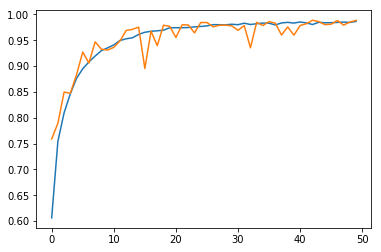

In [22]:
# accuracy
plt.plot(res.history['acc'])
plt.plot(res.history['val_acc'])

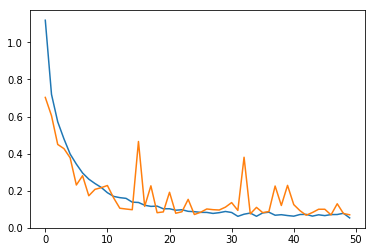

In [23]:
# loss
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])

In [24]:
# оценка модели на тестовых данных
score, acc = model.evaluate(X_test, y_test, batch_size=16)

3393/3393 [==============================] - 1s 172us/step


In [25]:
score, acc

(0.07006139364820677, 0.9885057471264368)

In [38]:
model.save('weights/model.hdf5')
model.save_weights('weights/model_weights.hdf5')